In [1]:
import glmnet_python
from glmnet import glmnet

# Import relevant modules and setup for calling glmnet
%matplotlib inline

import time
import sys
import os
import re
from itertools import compress
from glob import glob
import pickle

import tensorflow as tf # data is in TFRecord format

import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from scipy.io import loadmat

import numpy as np
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# glmnet has many deprecation warnings from using scipy.* instad of numpy.*
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def plot_distributions(y, y_hat):

    fig, axs = plt.subplots(2, 4, sharey=False, sharex=False, tight_layout=True)
    fig.set_size_inches(20,10)

    for ic in range(0,8):
        idx = np.unravel_index(ic, axs.shape)
        if ic < 4:
            axs[idx].set_title("Real %s"%names[ic])
            x = y[:,ic]        
        else:
            axs[idx].set_title("Predicted %s"%names[ic-4])
            x = y_hat[:,ic-4]
        axs[idx].hist(x, bins=20)

In [2]:
# Define constants
ncores = 28 # 56
names = ['DA', '5HT', 'pH', 'NE']
results_prefix = '/mnt/nfs/proj/in-vitro/Leonardo/glmnet/fits/'
prefix = os.path.join('/mnt/nfs/proj/in-vitro/Mark/four_analyte/slow/allin')
# good_probes = ['CF025']
good_probes = ['CF025', 'CF027']
# good_probes = ['CF025', 'CF027', 'CF057', 'CF064', 'CF066', 'CF078', 'CF081', 'CF082']
# nrecords_per_session = 1 # One is special, loads one sweep per concentration per TFRecord
# nrecords_per_session = 2 # Any other number loads that amount of records in sequence from each TFRecord
nrecords_per_session = -1 # Loads all records
val_ratio = .1
hold_probe = 0
# hold_probe = -1 # split data randomly


In [3]:
# Load data

start_time = time.time()

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    def atoi(text):
        return int(text) if text.isdigit() else text
    return [atoi(c) for c in re.split(r'(\d+)', text)]

def preprocess(serialized_example):
    features = tf.io.parse_example(
        serialized_example,
        features={
            'gram': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.string)
        })
    data = tf.io.decode_raw(features['gram'], tf.float32)
    label = tf.io.decode_raw(features['label'], tf.float32)
    data.set_shape((None, 999))
    label.set_shape((None, 4))
    return data, label

def merge_datasets(vfiles, projy=lambda x: x, asnumpy=False):
    yv = []
    yl = []
    for filename in vfiles:
        ds = tf.data.TFRecordDataset(filename)
        ds = ds.batch(batch_size=2**13)
        ds = ds.map(map_func=preprocess)
        for v,l in ds:
            v = np.array(v).astype(np.float64)
            l = np.array(l).astype(np.float64)
            l = np.apply_along_axis(projy, axis=1, arr=l) 
            if nrecords_per_session == 1:
                _, ulidx = np.unique(l, return_index=True, axis=0)
                yv.append(v[ulidx,:])
                yl.append(l[ulidx,:])
            elif nrecords_per_session > 0:
                yv.append(v[:nrecords_per_session,:])
                yl.append(l[:nrecords_per_session,:])
            else:
                yv.append(v)
                yl.append(l)
#             print(yv[-1].shape)
#             print(yl[-1].shape)       
    x = np.vstack(yv)
    y = np.vstack(yl)

    if asnumpy:
        return x,y
    else:
        d = tf.data.Dataset.from_tensor_slices((x, y))
        return d

if hold_probe < 0:
    all_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in good_probes
    ], [])

    x, y = merge_datasets(all_files, asnumpy=True)
    
    idxs = np.random.permutation(x.shape[0])
    lim = int(x.shape[0]*(1-val_ratio))
    d1idx = idxs[idxs[:lim]]
    d2idx = idxs[idxs[lim:]]
    x_train, y_train, x_val, y_val = x[d1idx,:], y[d1idx,:], x[d2idx,:], y[d2idx,:]
else:
    hold_probe = good_probes.pop(hold_probe)
    train_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in good_probes
    ], [])
    x_train, y_train = merge_datasets(train_files, asnumpy=True)
    
    val_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in [hold_probe]
    ], [])
    x_val, y_val = merge_datasets(val_files, asnumpy=True)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)  

print("--- %s seconds ---" % (time.time() - start_time))


(61650, 999) (61650, 4)
(61650, 999) (61650, 4)
--- 2.6020078659057617 seconds ---


In [5]:
print('Spliting training data into cells per concentration... ', end='')

# nint = 5
nint = 2
analytes = [0,1,3]
concentrations = [[]]*len(analytes)
ranges = [[]]*len(analytes)
for ic in range(len(analytes)):
    concentrations[ic] = np.linspace(min(y_train[:,analytes[ic]]), max(y_train[:,analytes[ic]]), nint+1)
#     print(c[ic])
    ranges[ic] = [concentrations[ic][ir] + np.mean(np.diff(concentrations[ic]))/2 for ir in range(len(concentrations[ic])-1)]
#     print(r[ic])

# use itertools product instead of nested for loops to make it easier to change the number of analytes
from itertools import product
split_data = {x: np.array([]) for x in product(range(nint), repeat=len(analytes))}
error = []
# print(len(split_data))
for x in split_data:

    # build binary mask for this cell
    good_data = np.full((y_train.shape[0],), True)
#     print(good_data.shape, good_data[0].__class__)
    for (ix,nx) in enumerate(x):
#         print(sum(good_data))
#         print(a[ix], nx)
        zeros = y_train[:,analytes[ix]] == 0.0
        above = y_train[:,analytes[ix]] > concentrations[ix][nx]
#         print(above.shape, above[0].__class__, c[ix][nx])
        below = y_train[:,analytes[ix]] < concentrations[ix][nx+1]
#         print(below.shape, below[0].__class__, c[ix][nx+1])
        interval = np.bitwise_or(np.bitwise_and(above, below), zeros)
#         print(interval.shape, interval[0].__class__, sum(interval))
        good_data = np.bitwise_and(good_data, interval)

#     print(sum(good_data))
    # save data
    split_data[x] = (x_train[good_data,:], y_train[good_data,:])
    
    y = split_data[x][1]
    means = np.array([np.mean(y[y[:,x]>0, x]) for x in range(4)])
#     print(means)
    expected_means = np.array([ranges[i][x[i]] for i in range(len(analytes))])
#     print(expected_means)
    error.append(np.sqrt( (means[np.array(analytes)] - expected_means)**2 ))

print(' done.')

Spliting training data into cells per concentration...  done.


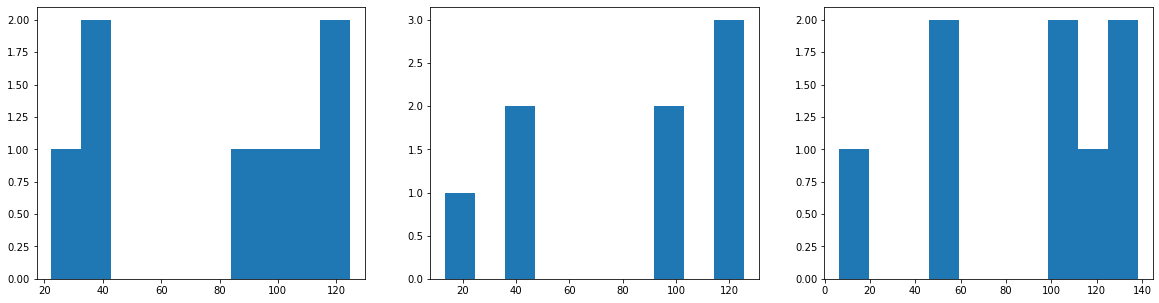

In [6]:
e = np.array(error)
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for idx in range(3):
    axs[idx].hist(e[:,idx])
plt.show()

In [ ]:
# fit GLMNET in parallel (ncores) with cross validation to find lambda

# alphas = [.9, 1.]
alpha = 1.0
models = {x: [] for x in split_data}
ncross = 10
nx = len(split_data)
for (ix, x) in enumerate(split_data):
    this_x_train, this_y_train = split_data[x]
    print(f'Computing {ncross} cross-validations for model {ix} of {nx} ({x}) ... ', end='')
    start_time = time.time()
    models[x] = cvglmnet(x = this_x_train.copy(), y = this_y_train.copy(), family='mgaussian', parallel=ncores, ptype = 'mse', nfolds = ncross, alpha=alpha)
    print(" took %s seconds" % (time.time() - start_time))

Computing 10 cross-validations for model 0 of 8 ((0, 0, 0)) ... 

In [ ]:
output_file = os.path.join(results_prefix, f'cf_alpha_1.0_{nint}x{nint}x{nint}.pickle')
print(output_file)
with open(output_file, 'wb') as f:
    pickle.dump(models, f)

In [ ]:

# find the model with predictions closest to original range (sum over all analytes) and compute RMSE of each analyte for that model 

# generate the predictions for each model
y_hats = np.zeros((len(models), y_val.shape[0], y_val.shape[1]))
for (ix, x) in enumerate(models):
    print(f'{ix} of {nx} ({x})')
    model = models[x]
# #     y_hat = cvglmnetPredict(fit, newx = x_val, s='lambda_min')
    y_hat = cvglmnetPredict(model, newx = x_val, s='lambda_1se')
#     y_hat = y_val[:,:,None]*(1.+0.1*np.random.randn(y_val.shape[0], y_val.shape[1], 1))
    y_hats[ix,:,:] = y_hat[:,:,0]

# compute the differences to original intervals
diff_y_hats = np.zeros(y_hats[:,:,analytes].shape)
for (ix,x) in enumerate(models):
    for ia in range(len(analytes)):
        diff_y_hats[ix,:,ia] = (y_hats[ix,:,analytes[ia]] - ranges[ia][x[ia]])**2

# find the model with sum of predictions closest to original intervals
model_e = np.sum(diff_y_hats,axis=2)
min_idx = model_e.argmin(axis=0)

# compute the RMSE for each sample (there is certainly a more pythonic way to do that, but that works)
rmse = np.zeros((4,), dtype=np.float64)
for (sample_idx, model_idx) in enumerate(min_idx):
    rmse += (y_hats[model_idx, sample_idx, :] - y_val[sample_idx, :])**2/y_val.shape[0]
rmse = np.sqrt(rmse) 

for (armse, name) in zip(rmse,names):
    print('%s: %4.5f'%(name,armse), flush=True)


In [26]:
x=np.array([ [[1,2],[3,4]], [[4,3],[2,1]], [[2,4],[1,4]] ])
idx_min = np.argmin(x,axis=0)
print(idx_min)
print(idx_min.choose(x))

[[0 0]
 [2 1]]
[[1 2]
 [1 1]]
